# Open Street Map network partitioning
---

## Imports

In [64]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from itertools import groupby
from operator import itemgetter

%matplotlib inline

In [65]:
# load GM road network from pickle (originally pulled from OSMX)
G_drive = nx.read_gpickle("pickle/OSM_street_network.gpickle")
G = nx.Graph(G_drive)

In [73]:
G.edges()[(398721038, 1126087651)]

{'osmid': 34495719,
 'name': 'Plank Lane',
 'highway': 'tertiary',
 'oneway': False,
 'length': 27.813}

In [71]:
edge_labels

{}

In [70]:
formatted_edge_labels

{}

In [ ]:
nx.set_node_attributes(G, {str(node): xx}, 'loc')

In [66]:
nx.write_shp(G, 'GM_netx_shp')

C:\ANACONDA3\envs\networks\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: write_shp is deprecated and will be removed in 3.0.See https://networkx.org/documentation/latest/auto_examples/index.html#geospatial.
  """Entry point for launching an IPython kernel.


TypeError: 'int' object is not subscriptable

In [41]:
list(G.nodes(data=True))[0:5]

[(398721038,
  {'y': 5927330.199041799,
   'x': 529715.0012583488,
   'osmid': 398721038,
   'highway': nan,
   'ref': nan,
   'lon': -2.5520905,
   'lat': 53.4940952}),
 (173539348,
  {'y': 5934483.030881222,
   'x': 524040.1553446054,
   'osmid': 173539348,
   'highway': nan,
   'ref': nan,
   'lon': -2.6370791,
   'lat': 53.558678}),
 (364904472,
  {'y': 5925656.606824867,
   'x': 530430.1252299964,
   'osmid': 364904472,
   'highway': nan,
   'ref': nan,
   'lon': -2.5414737,
   'lat': 53.4790114}),
 (2269904920,
  {'y': 5914853.17716691,
   'x': 557632.3688755617,
   'osmid': 2269904920,
   'highway': nan,
   'ref': nan,
   'lon': -2.1336019,
   'lat': 53.3796376}),
 (2269904922,
  {'y': 5914772.491049056,
   'x': 557591.168838199,
   'osmid': 2269904922,
   'highway': nan,
   'ref': nan,
   'lon': -2.1342359,
   'lat': 53.3789169})]

# Partitioning the graph into geographical chunks

In [42]:
# get tuple of x/y coordinates
locations = []

for node in G.nodes():
    locations.append(tuple([(G.nodes[node]['lon']), G.nodes[node]['lat']]))

In [43]:
# get min/max coordinates
min_x = min(locations,key=itemgetter(0))[0]
max_x = max(locations,key=itemgetter(0))[0]
min_y = min(locations,key=itemgetter(1))[1]
max_y = max(locations,key=itemgetter(1))[1]

In [44]:
# get corners of rectangle
sw = tuple([min_x, min_y])
nw = tuple([min_x, max_y])
ne = tuple([max_x, max_y])
se = tuple([max_x, min_y])

In [45]:
def getEquidistantPoints(p1, p2, parts):
    return zip(np.linspace(p1[0], p2[0], parts+1),
               np.linspace(p1[1], p2[1], parts+1))

In [46]:
# set at 26 parts for ease of using full alphabet

y = list(getEquidistantPoints((nw), (sw), 26))
x = list(getEquidistantPoints((sw), (se), 26))

ys = [x[1] for x in y]
xs = [x[0] for x in x]

In [47]:
X, Y = np.meshgrid(xs, ys)
grid = zip(X, Y)

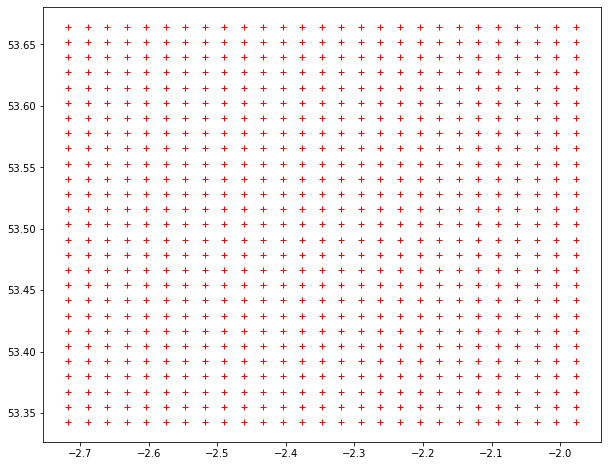

In [48]:
# plotting an example grid
plt.figure(figsize=(10,8))
plt.plot(X, Y, marker='+', color='red', linestyle='none');

In [49]:
df = pd.DataFrame()

x_square = (max_x - min_x)/26
y_square = (max_y - min_y)/26

def label_point(x, y):
    x_label = (x - min_x) // (x_square)
    y_label = chr(ord('Z') - int((y - min_y) // y_square))
    return f'{x_label}{y_label}'

In [50]:
# sense check extremeties
print(label_point(nw[0], nw[1]))
print(label_point(ne[0], ne[1]))
print(label_point(sw[0], sw[1]))
print(label_point(se[0], se[1]))

0.0A
26.0A
0.0Z
26.0Z


In [51]:
xx = []
for i in locations:
    xx.append(i[0])
    
yy = []
for i in locations:
    yy.append(i[1])

In [52]:
df['x'] = xx
df['y'] = yy

In [53]:
df['label'] = df[['x', 'y']].apply(lambda coord: label_point(*coord), axis=1)

In [54]:
#df

In [55]:
res = dict(zip(list(G.nodes()), df['label']))

In [56]:
nx.set_node_attributes(G, res, "sub_graph")

In [57]:
locations = dict(zip(list(G.nodes()), locations))
nx.set_node_attributes(G, locations, 'pos')

In [58]:
grid_refs = sorted(df['label'].unique())

In [59]:
# Sort the nodes by their role (this is required for the groupby to work)
sorted_by_role = sorted(G.nodes(data=True), key=lambda node_data: node_data[1]["sub_graph"])
# Group objects with same role together
grouped = groupby(sorted_by_role, key=lambda node_data: node_data[1]["sub_graph"])

subgraphs = dict()
for key, group in grouped:
     nodes_in_group, _ = zip(*list(group)) 
     subgraphs[key] = G.subgraph(nodes_in_group)

In [60]:
all_grid_refs = []

for i in range(26):
    for j in range(26):
        x = j
        y =  chr(ord('A') + int(i))
        all_grid_refs.append(f'{x}.0{y}')

## Label grid references 

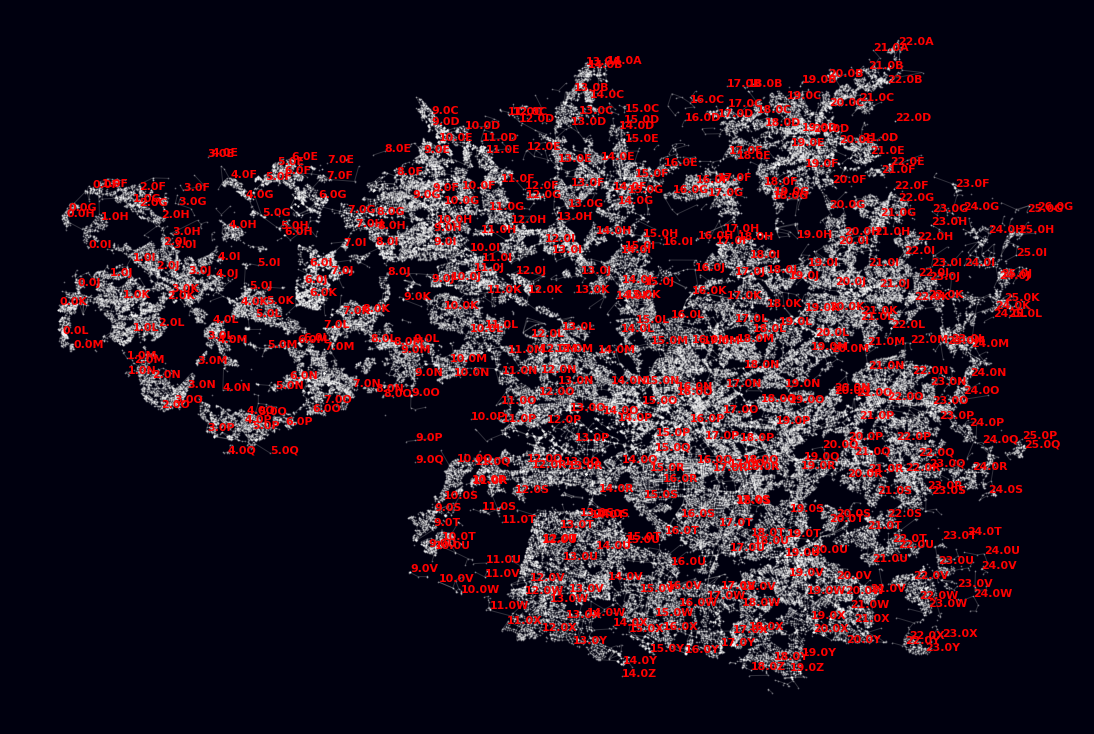

In [61]:
fig = plt.figure(figsize=(15,10))

for i in grid_refs:
    pos=nx.get_node_attributes(subgraphs[i],'pos')
    nx.draw(subgraphs[i], pos, node_size=1, node_color='white', edge_color='silver', alpha = 0.25)
    pos = list(pos.values())[0]
    x = pos[0]
    y = pos[1]
    plt.text(x,y, i, color = 'red', fontsize = 11, fontweight='bold')
fig.set_facecolor("#00000F")

In [62]:
# empty graph to populate areas of city with no road network
gg = nx.Graph()

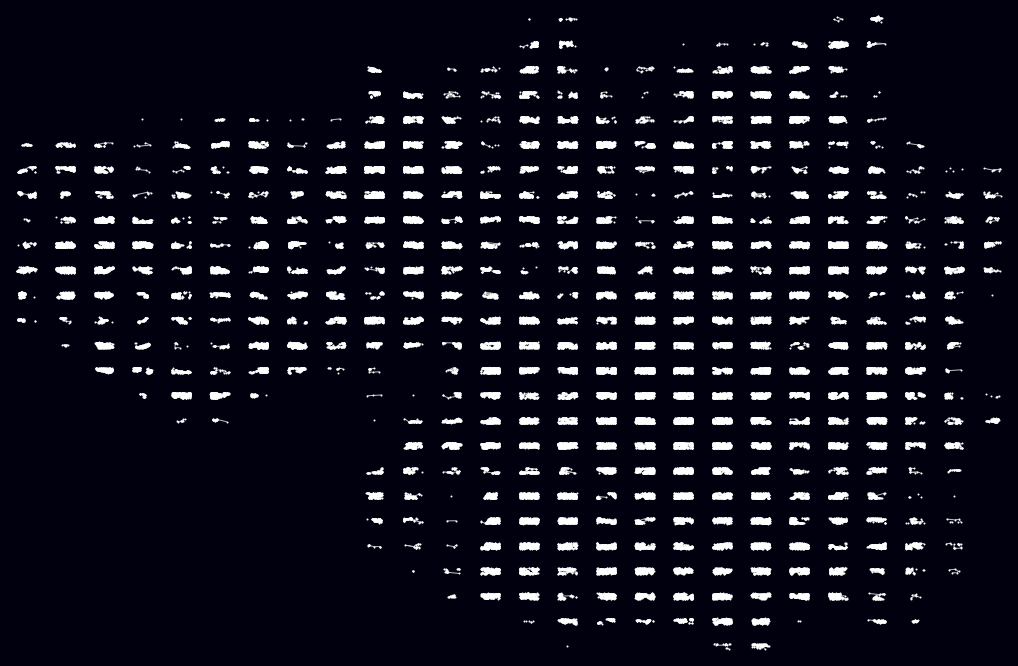

In [63]:
fig, axes = plt.subplots(nrows=26, ncols=26, figsize=(18,12))
fig.subplots_adjust(hspace =.001, wspace=.001)
ax = axes.flatten()
i=0

for i,j in enumerate(all_grid_refs):
    if j in grid_refs:
        pos = nx.get_node_attributes(subgraphs[j],'pos')
        nx.draw(subgraphs[j], pos, node_size=1, node_color='white', edge_color='silver', ax=ax[i])
        ax[i].set_axis_off()
        i+=1
        fig.set_facecolor("#00000F")
    else:
        nx.draw(gg, ax=ax[i])
        ax[i].set_axis_off()
        fig.set_facecolor("#00000F")
        i+=1

plt.show()

## Export individual networks to adjacency matrix 

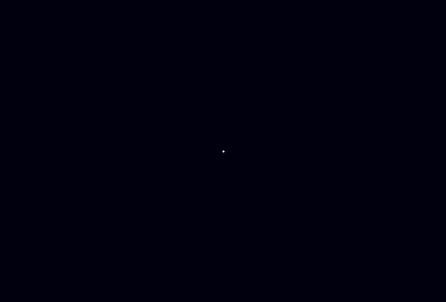

In [28]:
fig = plt.figure()
pos = nx.get_node_attributes(subgraphs["26.0G"],'pos')
nx.draw(subgraphs["26.0G"], node_size=1, node_color='white', edge_color='silver')
fig.set_facecolor("#00000F")

In [29]:
# del most eastlerly grid reference (only contains a single node)
del subgraphs['26.0G']

In [30]:
for i in all_grid_refs:
    if i in grid_refs:
        continue
    else:
        subgraphs[i] = gg

In [31]:
index_map = {v: i for i, v in enumerate(all_grid_refs)}
subgraphs = dict(sorted(subgraphs.items(), key=lambda pair: index_map[pair[0]]))

In [32]:
# populate empty areas will empty matrix
for key, value in subgraphs.items():
    if nx.is_empty(subgraphs[key]):
        subgraphs[key] = np.matrix([])
    else:
        subgraphs[key] = nx.adjacency_matrix(subgraphs[key]).todense()

In [33]:
subgraphs

{'0.0A': matrix([], shape=(1, 0), dtype=float64),
 '1.0A': matrix([], shape=(1, 0), dtype=float64),
 '2.0A': matrix([], shape=(1, 0), dtype=float64),
 '3.0A': matrix([], shape=(1, 0), dtype=float64),
 '4.0A': matrix([], shape=(1, 0), dtype=float64),
 '5.0A': matrix([], shape=(1, 0), dtype=float64),
 '6.0A': matrix([], shape=(1, 0), dtype=float64),
 '7.0A': matrix([], shape=(1, 0), dtype=float64),
 '8.0A': matrix([], shape=(1, 0), dtype=float64),
 '9.0A': matrix([], shape=(1, 0), dtype=float64),
 '10.0A': matrix([], shape=(1, 0), dtype=float64),
 '11.0A': matrix([], shape=(1, 0), dtype=float64),
 '12.0A': matrix([], shape=(1, 0), dtype=float64),
 '13.0A': matrix([[0, 1],
         [1, 0]], dtype=int32),
 '14.0A': matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
          0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 1, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

In [34]:
subgraphs['14.0A']

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0],
